Fully working example to compare:
- LinearGAM smooth spline (from pygam)
- Natural cubic spline interpolation (which interpolates every point)
- Improved natural spline via knot selection and backfitting

## Load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import csv
from sklearn.cluster import KMeans

df = pd.read_csv("spnbmd.csv")


# Calculate the percentage change in Spinal_BMD for each idnum
df["Spinal_BMD"] = df.groupby("idnum")["Spinal_BMD"].pct_change()

df.dropna(inplace=True)

N = len(df)

df['Gender'] = df['Gender'].astype('category')
df['Gender_code'] = df['Gender'].cat.codes
X = df[['Age', 'Gender_code']].values
y = df['Spinal_BMD'].values

## 2. Standard Natural Cubic Spline Functions

In [ ]:
def natural_cubic_spline_coeff(x, y):
    """
    Compute natural cubic spline coefficients.
    Returns arrays: a, b, c, d for each interval and the knots.
    """

    # Remove duplicates by taking unique x and corresponding y (or average duplicates if needed)
    unique_x, idx = np.unique(x, return_index=True)
    x = unique_x
    y = y[idx]


    n = len(x) - 1
    h = np.diff(x)
    A = np.zeros((n+1, n+1))
    b_vec = np.zeros(n+1)
    # Natural boundary conditions
    A[0, 0] = 1
    A[n, n] = 1
    for j in range(1, n):
        A[j, j-1] = h[j-1]
        A[j, j]   = 2 * (h[j-1] + h[j])
        A[j, j+1] = h[j]
        b_vec[j]  = 3 * ((y[j+1] - y[j]) / h[j] - (y[j] - y[j-1]) / h[j-1])
    c = np.linalg.solve(A, b_vec)
    b_coeff = np.zeros(n)
    d_coeff = np.zeros(n)
    a_coeff = y[:-1]
    for j in range(n):
        b_coeff[j] = (y[j+1] - y[j]) / h[j] - h[j]*(2*c[j] + c[j+1])/3
        d_coeff[j] = (c[j+1] - c[j]) / (3*h[j])
    return a_coeff, b_coeff, c[:-1], d_coeff, x

def evaluate_spline(x_eval, knots, a, b, c, d):
    """
    Evaluate the natural cubic spline at points x_eval.
    """
    x_eval = np.atleast_1d(x_eval)
    y_eval = np.zeros_like(x_eval)
    for i, xi in enumerate(x_eval):
        j = np.searchsorted(knots, xi) - 1
        j = np.clip(j, 0, len(a)-1)
        dx = xi - knots[j]
        y_eval[i] = a[j] + b[j]*dx + c[j]*(dx**2) + d[j]*(dx**3)
    return y_eval

def natural_spline(data):
    """
    Fits a natural cubic spline to 2D data (first column: x, second: y)
    and returns a function that evaluates the spline.
    """
    x = data[:, 0]
    y = data[:, 1]
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    a, b, c, d, knots = natural_cubic_spline_coeff(x_sorted, y_sorted)
    def spline_func(x_val):
        return evaluate_spline(x_val, knots, a, b, c, d)
    return spline_func

## linearGAM_competitor_improved_spline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assume natural_spline(datapoints) is defined elsewhere.
# It takes an array of [knot_x, average_residual] pairs and returns a callable spline function.

def linearGAM_competitor_improved_spline(x, y, feature_types, verbose=False):
    """
    Fits an additive model (GAM) of the form:
        y = alpha + sum_{j} f_j(x_j)
    where each f_j is either a natural spline or a linear function.

    Parameters:
        x : 2D numpy array, shape (N, num_features)
        y : 1D or 2D numpy array, shape (N,) or (N, 1)
        feature_types : list of strings of length num_features
                        each element should be 's' (spline) or 'l' (linear)
        verbose : bool, if True, intermediate plots are shown

    Returns:
        gam_function: callable that takes x_eval (2D array of shape (num_points, num_features))
                      and returns the fitted response.
    """
    # Ensure y is 2D
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    THRESHOLD = 1e-5  # Convergence threshold for backfitting updates
    KNOT_PERCENTILE = 10  # Used to determine number of clusters for spline features
    N, num_features = x.shape

    # Global intercept: the overall average of y.
    alpha_hat = np.average(y)

    # Initialize function estimates for each feature to be zero.
    # f_i[j](value) returns the current contribution of feature j.
    f_i = [np.vectorize(lambda a: 0) for _ in range(num_features)]

    # Precompute k-means clustering for features that are to be modeled as splines.
    # For linear features, no knot data is needed.
    knot_data = [None] * num_features
    n_clusters = int(100 / KNOT_PERCENTILE) + 1  # e.g., for KNOT_PERCENTILE=10, n_clusters=11
    for i in range(num_features):
        if feature_types[i] == 's':
            data = x[:, i].reshape(-1, 1)
            unique_vals = np.unique(data)
            n_clusters_feature = min(n_clusters, len(unique_vals))
            kmeans = KMeans(n_clusters=n_clusters_feature, random_state=0).fit(data)
            centers = kmeans.cluster_centers_.flatten()
            labels = kmeans.labels_
            knot_data[i] = (centers, labels)

    # Backfitting loop
    count = 0
    error = np.inf
    while error > THRESHOLD or count == 0:
        feature = count % num_features

        # Compute the current residuals by removing the effects of all other features.
        # This is: residual = y - alpha_hat - sum_{j != feature} f_j(x[:, j])
        other_effect = np.sum(
            np.array([f_i[j](x[:, j]) for j in range(num_features) if j != feature]),
            axis=0
        ).reshape(-1, 1)
        residuals_all = y - alpha_hat - other_effect  # shape (N, 1)
        residuals_all = residuals_all.flatten()

        # Update the current feature depending on whether it's spline or linear.
        if feature_types[feature] == 's':
            # Spline Update for Feature 'feature'
            centers_unsorted, labels = knot_data[feature]
            unique_labels = np.unique(labels)

            # For each cluster, compute the average residual.
            avg_residuals = []
            for lab in unique_labels:
                avg_res = np.mean(residuals_all[labels == lab])
                avg_residuals.append(avg_res)
            avg_residuals = np.array(avg_residuals)
            # Get corresponding centers (each label corresponds to a center given by k-means)
            centers = np.array([centers_unsorted[lab] for lab in unique_labels])
            # Sort the clusters by their center values so that the spline is fit on an ordered set.
            sort_order = np.argsort(centers)
            sorted_centers = centers[sort_order]
            sorted_avg_residuals = avg_residuals[sort_order]

            # Prepare datapoints for spline fitting: each row is [knot_x, average_residual].
            datapoints_feature = np.column_stack([sorted_centers, sorted_avg_residuals])
            new_f_feature = natural_spline(datapoints_feature)

            # Center the spline function so that its average over the knot centers is zero.
            def get_new_f_feature_normalized(f, knot_x):
                def new_f_feature_normalized(datapoints):
                    return f(datapoints) - np.average(f(knot_x))
                return np.vectorize(new_f_feature_normalized)
            new_f_feature_normalized = get_new_f_feature_normalized(new_f_feature, sorted_centers)

            if verbose:
                # Plot intermediate spline fits.
                x_vals = np.linspace(np.min(x[:, feature]), np.max(x[:, feature]), num=50)
                plt.figure()
                plt.plot(x_vals, new_f_feature(x_vals), 'g', label='New Spline')
                plt.plot(x_vals, new_f_feature_normalized(x_vals), 'r', label='Centered Spline')
                plt.plot(x_vals, f_i[feature](x_vals), 'b', label='Previous Estimate')
                plt.scatter(sorted_centers, sorted_avg_residuals, c='r', label='Knot Centroids')
                plt.title(f"Feature {feature} Spline Update")
                plt.legend()
                plt.show()

            # Evaluate the maximum change (error) over the knot centroids.
            error = np.max(np.abs(new_f_feature_normalized(sorted_centers) - f_i[feature](sorted_centers)))
            f_i[feature] = new_f_feature_normalized

        elif feature_types[feature] == 'l':
            # Linear Update for Feature 'feature'
            X_feature = x[:, feature]
            # Center the feature to avoid identifiability issues.
            mean_feature = np.mean(X_feature)
            X_centered = X_feature - mean_feature

            # Compute the least-squares coefficient (beta) for the linear term.
            var = np.dot(X_centered, X_centered)
            if var == 0:
                beta = 0.0
            else:
                beta = np.dot(X_centered, residuals_all) / var
            # Define the new linear function.
            new_f_feature = lambda x_val: beta * (x_val - mean_feature)

            # Compute the update error over the observed values.
            error = np.max(np.abs(new_f_feature(X_feature) - f_i[feature](X_feature)))

            # Update the function estimate for this feature.
            f_i[feature] = np.vectorize(new_f_feature)

            if verbose:
                x_vals = np.linspace(np.min(X_feature), np.max(X_feature), num=50)
                plt.figure()
                plt.plot(x_vals, new_f_feature(x_vals), 'g', label='New Linear')
                plt.plot(x_vals, f_i[feature](x_vals), 'b', label='Previous Estimate')
                plt.scatter(X_feature, residuals_all, c='r', label='Data Points')
                plt.title(f"Feature {feature} Linear Update")
                plt.legend()
                plt.show()
        else:
            raise ValueError(f"Invalid feature type '{feature_types[feature]}' for feature {feature}. Use 's' for spline or 'l' for linear.")

        count += 1

    # Define the final GAM function.
    def gam_function(x_eval):
        # x_eval should be a 2D array with shape (num_points, num_features)
        # Compute the predicted value as alpha_hat plus the sum of contributions from each feature.
        return alpha_hat + np.sum(np.array([f_i[i](x_eval[:, i]) for i in range(num_features)]), axis=0)

    return gam_function


## Compare performance of cubic smooth spline vs standard cubic spline vs cubic smooth spline competitor

(A) GAM smooth spline using pygam (as in your working example)
(B) Standard Natural Cubic Spline Interpolation (per gender)
(C) Improved Natural Spline via Backfitting

C:\Users\luuke\miniconda3\envs\151aprojnew\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


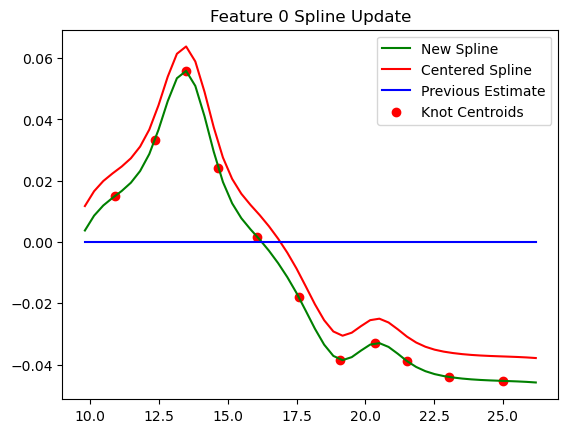

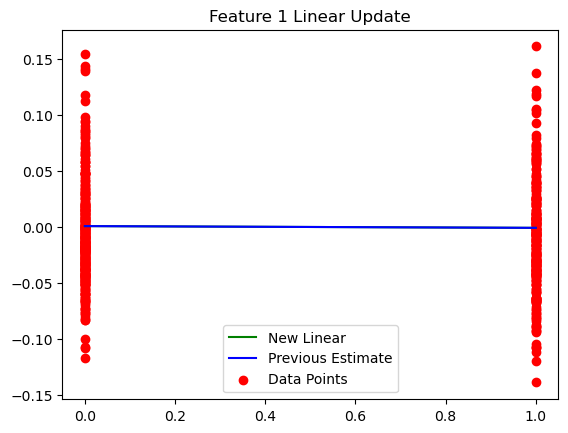

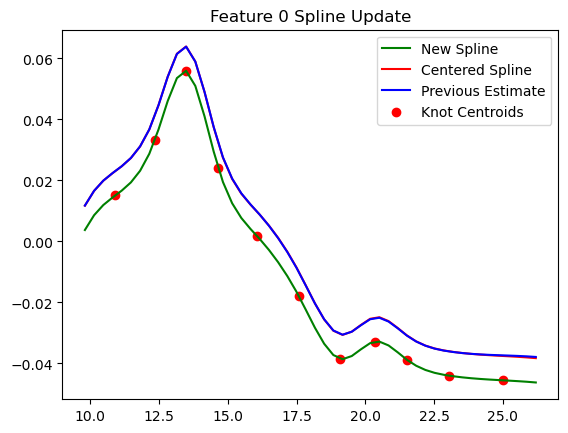

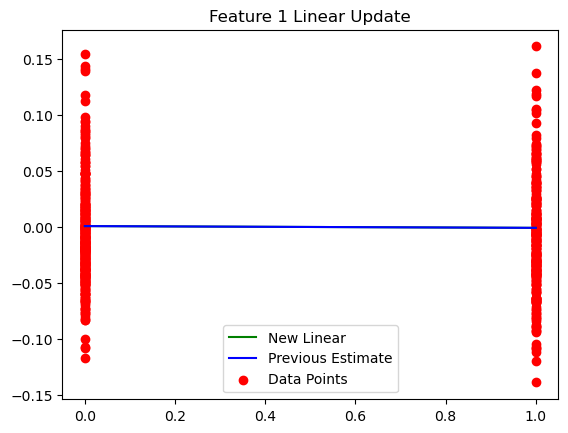

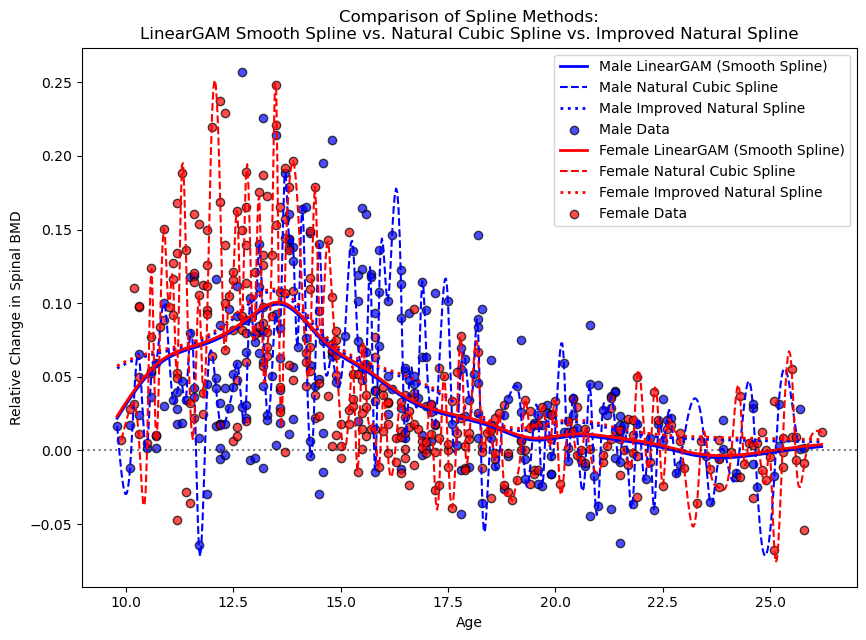

In [ ]:
# (A) GAM smooth spline using pygam (as in your working example)
gam = LinearGAM(s(0) + f(1)).fit(X, y)

# (B) Standard Natural Cubic Spline Interpolation (per gender)
# (We will fit a separate spline on the sorted Age for each gender.)

# (C) Improved Natural Spline via Backfitting
# Turn off verbose plotting for backfitting iterations

feature_types = ['s', 'l']

improved_model = linearGAM_competitor_improved_spline(X, y, feature_types, verbose=True)


unique_genders = df['Gender'].unique()
colors = {'Male': 'blue', 'Female': 'red'}

plt.figure(figsize=(10, 7))
age_grid_overall = np.linspace(df['Age'].min(), df['Age'].max(), N)

for gender in unique_genders:
    # For methods that use gender as an input, get the corresponding code.
    g_code = df.loc[df['Gender'] == gender, 'Gender_code'].iloc[0]

    # (A) Predictions from LinearGAM
    X_grid = np.column_stack([age_grid_overall, np.full_like(age_grid_overall, g_code)])
    y_pred_gam = gam.predict(X_grid)
    plt.plot(age_grid_overall, y_pred_gam, color=colors[gender],
          linewidth=2, label=f"{gender} LinearGAM (Smooth Spline)")

    # (B) Predictions from Natural Cubic Spline interpolation
    subset = df[df['Gender'] == gender].sort_values(by='Age')
    age_sorted = subset['Age'].values
    bmd_sorted = subset['Spinal_BMD'].values
    a_coeff, b_coeff, c_coeff, d_coeff, knots = natural_cubic_spline_coeff(age_sorted, bmd_sorted)
    age_grid_gender = np.linspace(age_sorted.min(), age_sorted.max(), N)
    y_pred_natural = evaluate_spline(age_grid_gender, knots, a_coeff, b_coeff, c_coeff, d_coeff)
    plt.plot(age_grid_gender, y_pred_natural, color=colors[gender],
          linestyle='--', linewidth=1.5, label=f"{gender} Natural Cubic Spline")

    # (C) Predictions from Improved GAM Natural Spline
    X_grid_percentile = np.column_stack([age_grid_overall, np.full_like(age_grid_overall, g_code)])
    y_pred_improved = improved_model(X_grid_percentile)
    plt.plot(age_grid_overall, y_pred_improved, color=colors[gender], linestyle=':',
              linewidth=2, label=f"{gender} Improved Natural Spline")

    # Scatter raw data for the gender
    plt.scatter(subset['Age'], subset['Spinal_BMD'], color=colors[gender],
                alpha=0.7, edgecolor='k', label=f"{gender} Data")

plt.axhline(y=0, color='k', linestyle=':', alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Relative Change in Spinal BMD")
plt.title("Comparison of Spline Methods:\nLinearGAM Smooth Spline vs. Natural Cubic Spline vs. Improved Natural Spline")
plt.legend()
plt.show()


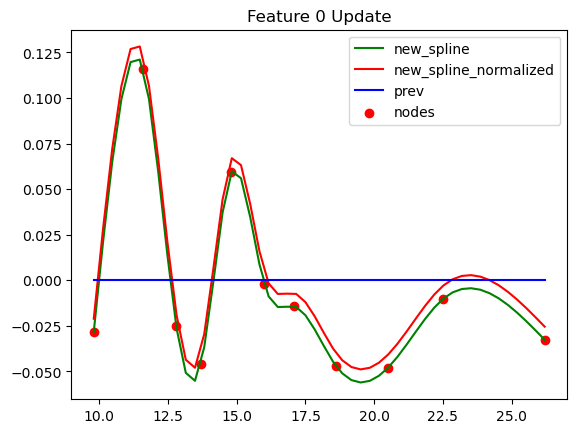

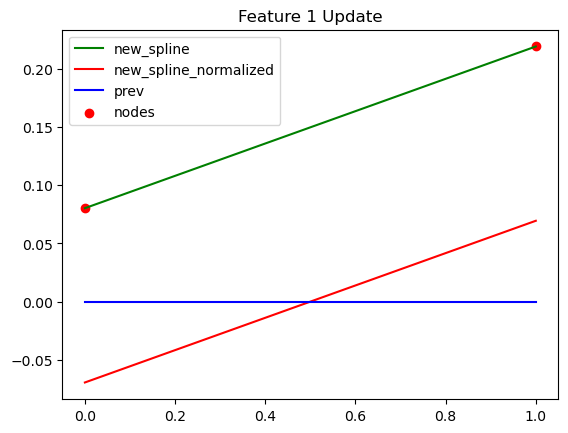

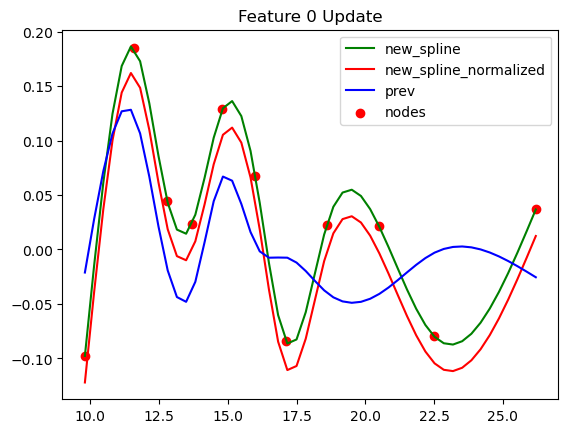

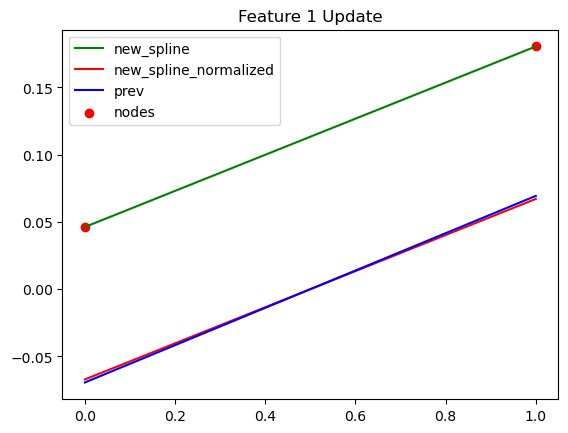

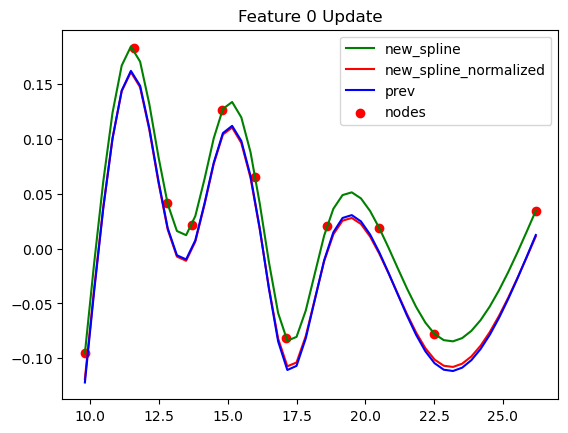

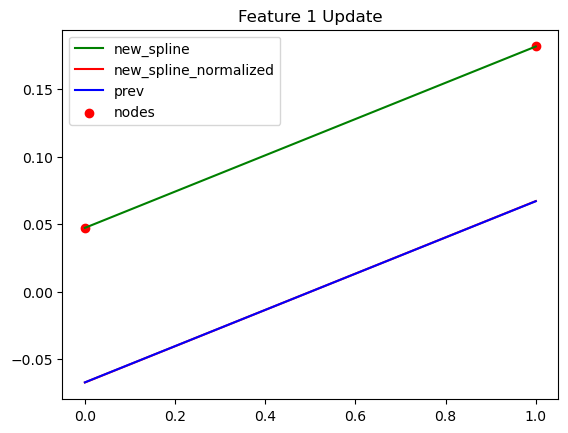

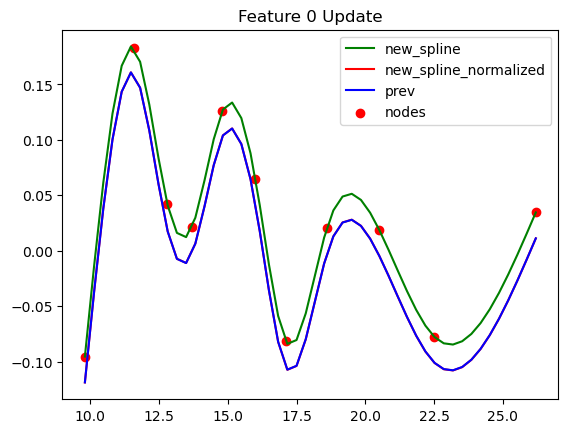

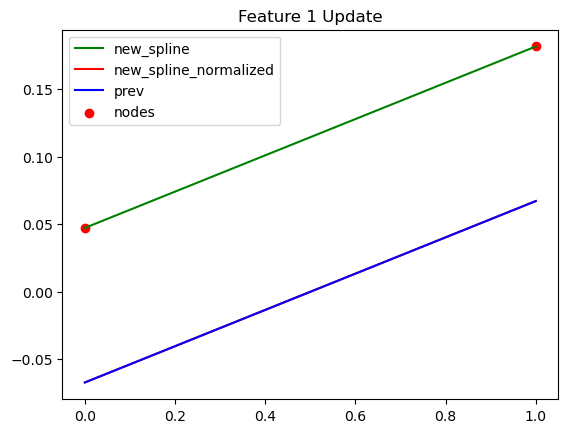

In [ ]:
def get_knots_percentile_method(x, y, percentile):
    """
    Select knot indices for each feature based on the given percentile.
    """
    assert percentile > 0 and percentile <= 100
    N = len(x)
    num_features = x.shape[1]
    sorted_features_idx = [
        np.lexsort((y.reshape(-1,), x[:, i].reshape(-1,))) for i in range(num_features)
    ]
    split_idx = [0]
    current = 0
    step_size = int(np.ceil(N * (percentile / 100)))
    while current + step_size < N:
        current += step_size
        split_idx.append(current)
    if split_idx[-1] != N-1:
        split_idx.append(N-1)
    split_idx = np.array(split_idx).astype(int)
    knots_features_idx = [ idx[split_idx] for idx in sorted_features_idx ]
    # Remove duplicate x values for each feature
    for feature, idx in enumerate(knots_features_idx):
        x_idx = x[idx, feature]
        non_dupe_idx = list(dict(zip(x_idx, idx)).values())
        knots_features_idx[feature] = non_dupe_idx
    return knots_features_idx



def fit_gam_natural_spline_percentile_method(x, y, verbose=False):
    """
    Fits an additive model (GAM) using natural cubic splines with
    selected knots and a backfitting algorithm.
    Returns a function that evaluates the fitted GAM.
    """
    # Ensure y is 2D
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    # Constants for backfitting
    THRESHOLD = 1e-5  # Convergence threshold
    KNOT_PERCENTILE = 10  # Use 10th percentile for knot selection
    N = len(y)
    num_features = x.shape[1]

    alpha_hat = np.average(y)  # global intercept
    # Initialize spline functions to zero for each feature
    f_i = [np.vectorize(lambda a: 0) for _ in range(num_features)]

    # Select knot indices for each feature
    knots_features_idx = get_knots_percentile_method(x, y, KNOT_PERCENTILE)

    count = 0
    error = np.inf
    while error > THRESHOLD or count == 0:
        feature = count % num_features
        knots_idx = knots_features_idx[feature]
        # Compute residuals excluding the current feature's effect
        other_effect = np.sum(
            np.array([f_i[k](x[knots_idx, k]) for k in range(num_features) if k != feature]),
            axis=0
        ).reshape(-1, 1)
        residuals = y[knots_idx] - alpha_hat - other_effect
        # Prepare data for spline fitting: first column is x, second is residuals
        datapoints_feature = np.hstack([x[knots_idx, feature].reshape(-1, 1), residuals])
        new_f_feature = natural_spline(datapoints_feature)

        # Center the spline function so that its average over the knots is zero
        def get_new_f_feature_normalized(f, data, knots, feature):
            def new_f_feature_normalized(datapoints):
                return f(datapoints) - np.average(f(data[knots, feature]))
            return np.vectorize(new_f_feature_normalized)
        new_f_feature_normalized = get_new_f_feature_normalized(new_f_feature, x, knots_idx, feature)

        # (Optional) Plot intermediate spline fits if verbose is True.
        if verbose:
            x_vals = np.linspace(np.min(x[:, feature]), np.max(x[:, feature]), num=50)
            plt.figure()
            plt.plot(x_vals, new_f_feature(x_vals), 'g', label='new_spline')
            plt.plot(x_vals, new_f_feature_normalized(x_vals), 'r', label='new_spline_normalized')
            plt.plot(x_vals, f_i[feature](x_vals), 'b', label='prev')
            plt.scatter(x[knots_idx, feature], residuals, c='r', label='nodes')
            plt.title(f"Feature {feature} Update")
            plt.legend()
            plt.show()

        error = np.max(np.abs(new_f_feature_normalized(x[knots_idx, feature]) - f_i[feature](x[knots_idx, feature])))
        f_i[feature] = new_f_feature_normalized
        count += 1

    def gam_function(x_eval):
        # x_eval should be a 2D array with shape (num_points, num_features)
        return alpha_hat + np.sum(np.array([f_i[i](x_eval[:, i]) for i in range(num_features)]), axis=0)
    return gam_function


percentile_model = fit_gam_natural_spline_percentile_method(X, y, verbose=True)



## The best plot possible (including percentile)

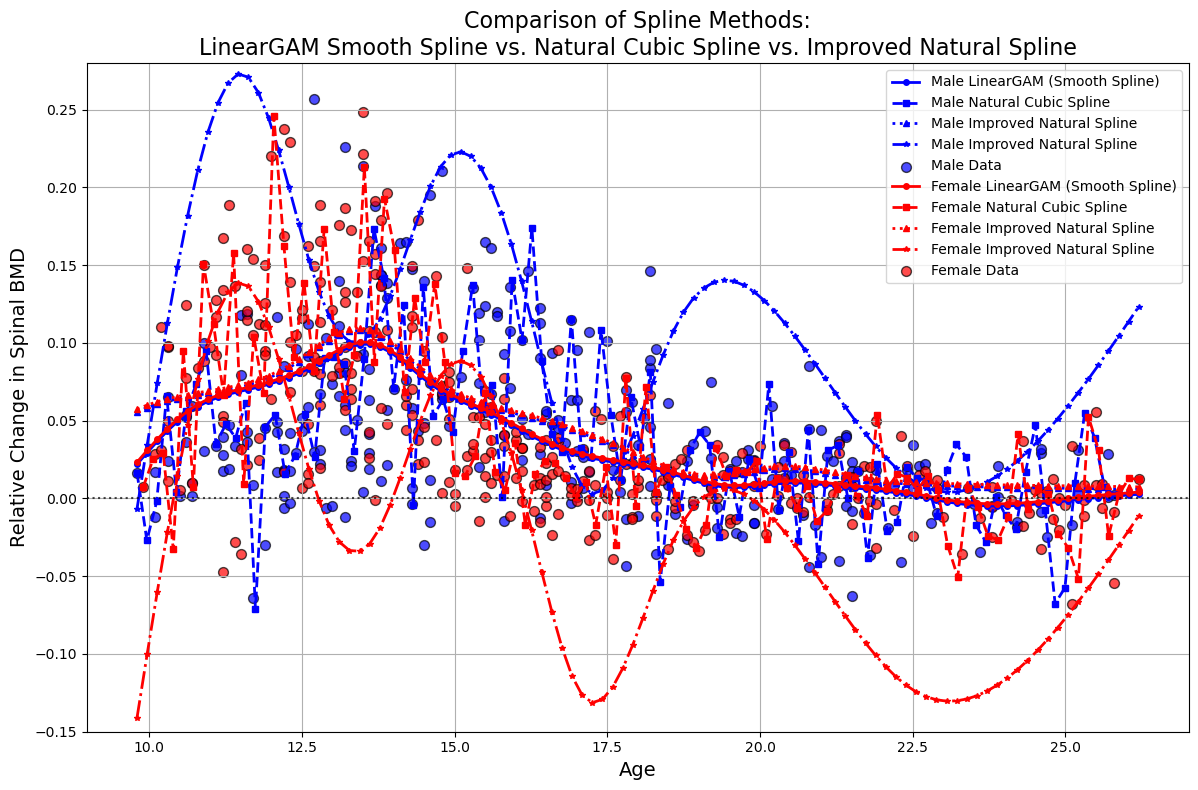

In [ ]:

# Define figure size and grid
plt.figure(figsize=(12, 8))
plt.grid(True)

unique_genders = df['Gender'].unique()
colors = {'Male': 'blue', 'Female': 'red'}
N = 100  # or your desired grid resolution

# Prepare age grid for overall predictions
age_grid_overall = np.linspace(df['Age'].min(), df['Age'].max(), N)

for gender in unique_genders:
    # Get gender code and subset data
    g_code = df.loc[df['Gender'] == gender, 'Gender_code'].iloc[0]
    subset = df[df['Gender'] == gender].sort_values(by='Age')

    # (A) Predictions from LinearGAM (Smooth Spline)
    X_grid = np.column_stack([age_grid_overall, np.full_like(age_grid_overall, g_code)])
    y_pred_gam = gam.predict(X_grid)
    plt.plot(age_grid_overall, y_pred_gam, color=colors[gender],
             linewidth=2, marker='o', markersize=4,
             label=f"{gender} LinearGAM (Smooth Spline)")

    # (B) Predictions from Natural Cubic Spline interpolation
    age_sorted = subset['Age'].values
    bmd_sorted = subset['Spinal_BMD'].values
    a_coeff, b_coeff, c_coeff, d_coeff, knots = natural_cubic_spline_coeff(age_sorted, bmd_sorted)
    age_grid_gender = np.linspace(age_sorted.min(), age_sorted.max(), N)
    y_pred_natural = evaluate_spline(age_grid_gender, knots, a_coeff, b_coeff, c_coeff, d_coeff)
    plt.plot(age_grid_gender, y_pred_natural, color=colors[gender],
             linestyle='--', linewidth=2, marker='s', markersize=4,
             label=f"{gender} Natural Cubic Spline")

    # (C) Predictions from Improved GAM Natural Spline
    X_grid_improved = np.column_stack([age_grid_overall, np.full_like(age_grid_overall, g_code)])
    y_pred_improved = improved_model(X_grid_improved)
    plt.plot(age_grid_overall, y_pred_improved, color=colors[gender],
             linestyle=':', linewidth=2, marker='^', markersize=4,
             label=f"{gender} Improved Natural Spline")


    # (D) Predictions from percentile GAM Natural Spline
    X_grid_percentile = np.column_stack([age_grid_overall, np.full_like(age_grid_overall, g_code)])
    y_pred_percentile = percentile_model(X_grid_percentile)
    plt.plot(age_grid_overall, y_pred_percentile, color=colors[gender],
             linestyle='-.', linewidth=2, marker='*', markersize=4,
             label=f"{gender} Improved Natural Spline")

    # Scatter raw data for the gender
    plt.scatter(subset['Age'], subset['Spinal_BMD'], color=colors[gender],
                alpha=0.7, edgecolor='k', s=50,
                label=f"{gender} Data")

# Horizontal reference line at y=0
plt.axhline(y=0, color='k', linestyle=':', alpha=0.7)

plt.xlabel("Age", fontsize=14)
plt.ylabel("Relative Change in Spinal BMD", fontsize=14)
plt.title("Comparison of Spline Methods:\nLinearGAM Smooth Spline vs. Natural Cubic Spline vs. Improved Natural Spline",
          fontsize=16)

# Position the legend outside the plot to reduce clutter
plt.legend(bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.ylim(-0.15, 0.28)
plt.show()

Note that in the code above, you can comment out different plot to make the plot look better

### Summary stats

In [ ]:
print("Cubic smooth spline")
for gender in unique_genders:
    subset = df[df['Gender'] == gender].sort_values(by='Age')
    X = subset[['Age', 'Gender_code']].to_numpy()
    true_y = subset["Spinal_BMD"].to_numpy()
    y_pred = gam.predict(X)

    true_mean = np.average(true_y)
    SS_res = np.sum((y_pred - true_y) ** 2)
    SS_tot = np.sum((true_y - true_mean) ** 2)
    R2 = 1 - SS_res/SS_tot

    RMSE = np.sqrt(np.average((y_pred - true_y) ** 2))
    MAE = np.average(np.abs(y_pred - true_y))
    print(f'gender: {gender}')
    print(f'R2: {R2}, RMSE: {RMSE}, MAE: {MAE}')

Cubic smooth spline
gender: Male
R2: 0.181489183611667, RMSE: 0.04904282896695486, MAE: 0.038012883161060405
gender: Female
R2: 0.46850402666508073, RMSE: 0.04370091672049759, MAE: 0.03287155150264425


In [ ]:
print("K-means knots with natural cubic spline")
for gender in unique_genders:
    subset = df[df['Gender'] == gender].sort_values(by='Age')
    X = subset[['Age', 'Gender_code']].to_numpy()
    true_y = subset["Spinal_BMD"].to_numpy()
    y_pred = improved_model(X)

    true_mean = np.average(true_y)
    SS_res = np.sum((y_pred - true_y) ** 2)
    SS_tot = np.sum((true_y - true_mean) ** 2)
    R2 = 1 - SS_res/SS_tot

    RMSE = np.sqrt(np.average((y_pred - true_y) ** 2))
    MAE = np.average(np.abs(y_pred - true_y))
    print(f'gender: {gender}')
    print(f'R2: {R2}, RMSE: {RMSE}, MAE: {MAE}')

K-means knots with natural cubic spline
gender: Male
R2: 0.15577990728571878, RMSE: 0.04980708724512792, MAE: 0.03917638687066216
gender: Female
R2: 0.4424157918758561, RMSE: 0.04476058878192626, MAE: 0.035064190245857045


In [ ]:
print("Percentile knots with natural cubic spline")
for gender in unique_genders:
    subset = df[df['Gender'] == gender].sort_values(by='Age')
    X = subset[['Age', 'Gender_code']].to_numpy()
    true_y = subset["Spinal_BMD"].to_numpy()
    y_pred = percentile_model(X)

    true_mean = np.average(true_y)
    SS_res = np.sum((y_pred - true_y) ** 2)
    SS_tot = np.sum((true_y - true_mean) ** 2)
    R2 = 1 - SS_res/SS_tot

    RMSE = np.sqrt(np.average((y_pred - true_y) ** 2))
    MAE = np.average(np.abs(y_pred - true_y))
    print(f'gender: {gender}')
    print(f'R2: {R2}, RMSE: {RMSE}, MAE: {MAE}')

Percentile knots with natural cubic spline
gender: Male
R2: -3.12108225919762, RMSE: 0.11004465270929341, MAE: 0.08802032066234132
gender: Female
R2: -1.4219749637421737, RMSE: 0.09328791416698026, MAE: 0.07572499679214448


## Another example to illustrate how backfitting and knot selection works

data generating process is
$$
Y = np.sin(2 * np.pi * X[:, 0]) + 0.5 * np.cos(2 * np.pi * X[:, 1]) + np.random.normal(0, 0.1, 100)
$$

C:\Users\luuke\miniconda3\envs\151aprojnew\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\luuke\miniconda3\envs\151aprojnew\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


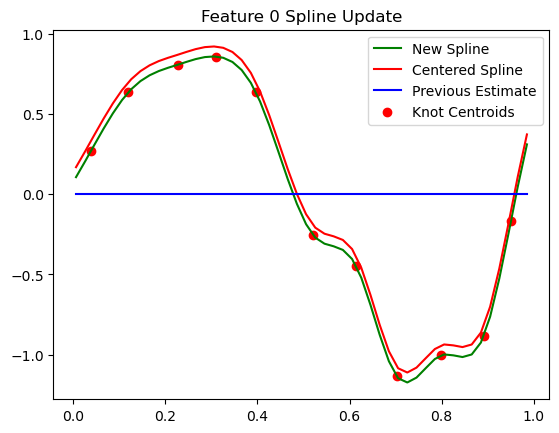

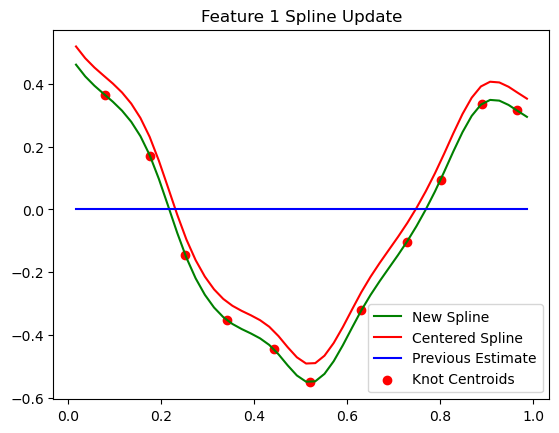

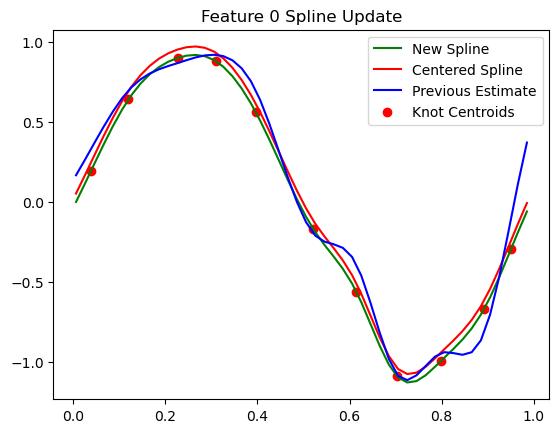

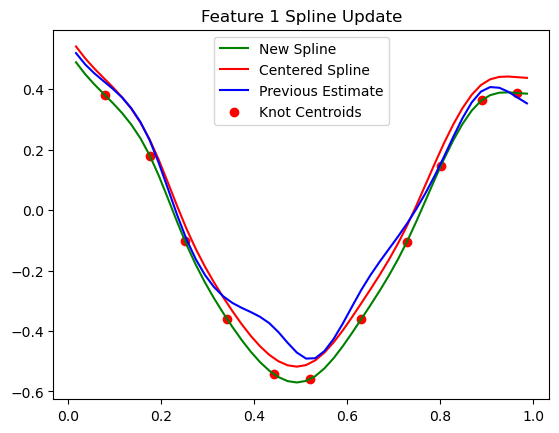

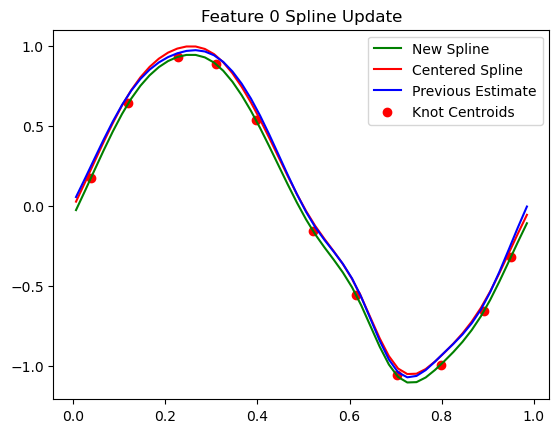

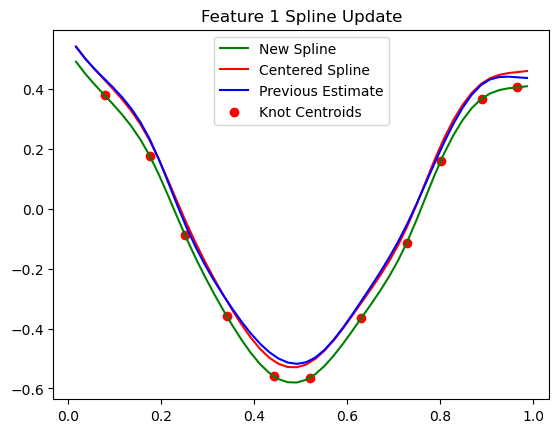

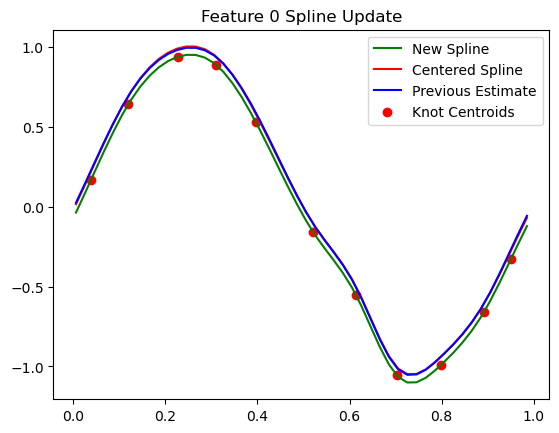

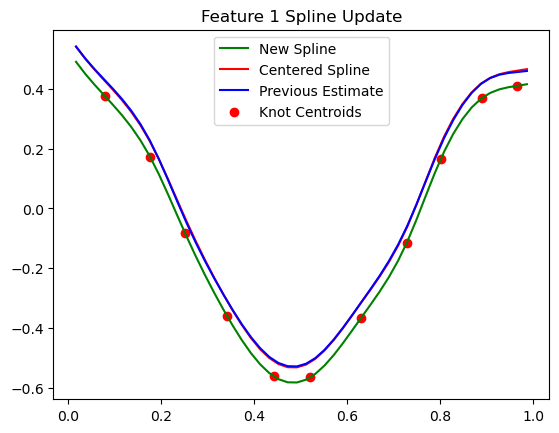

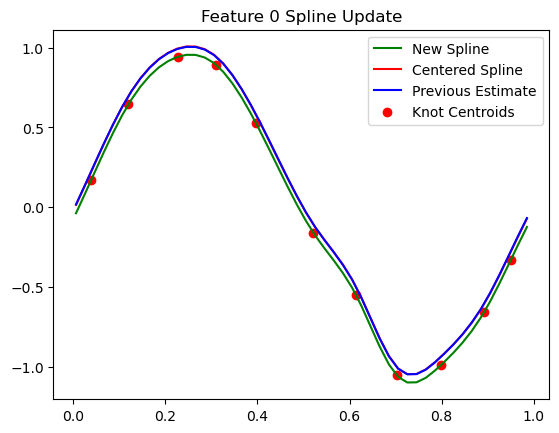

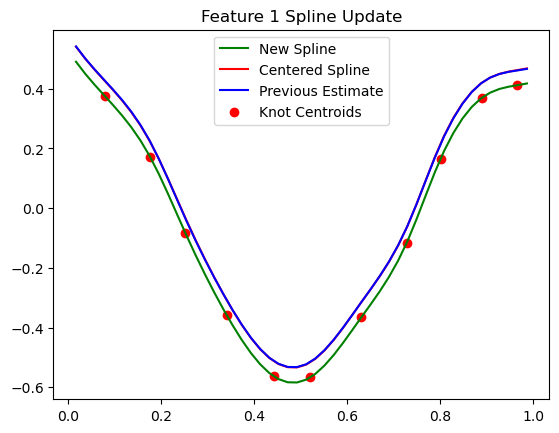

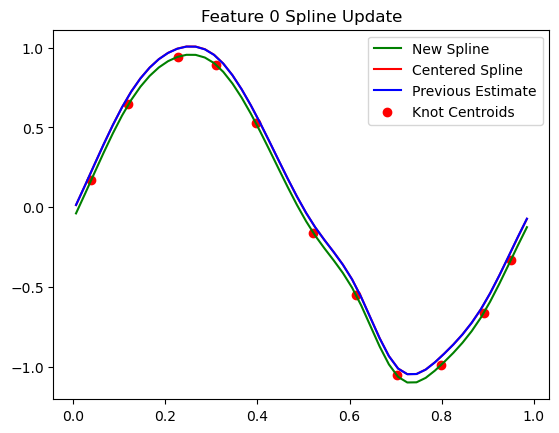

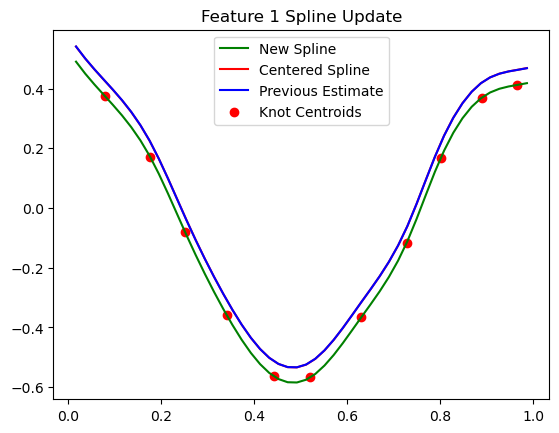

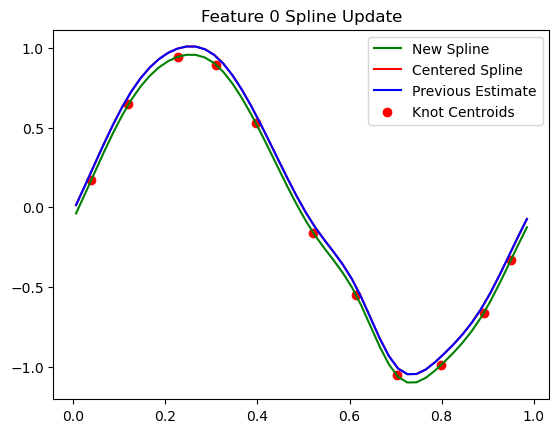

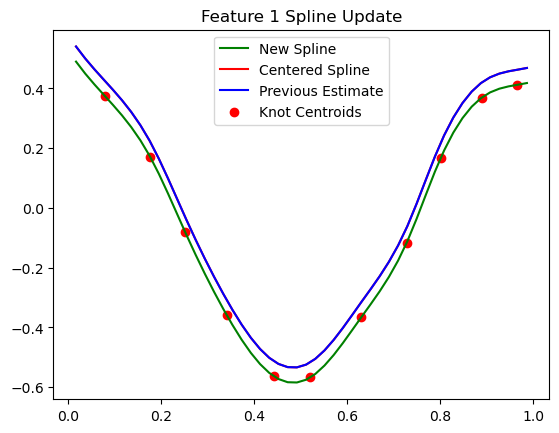

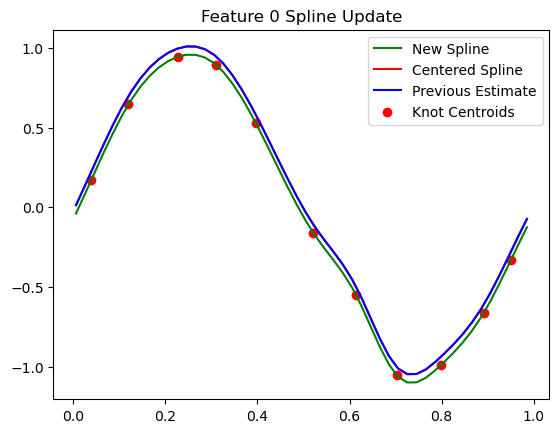

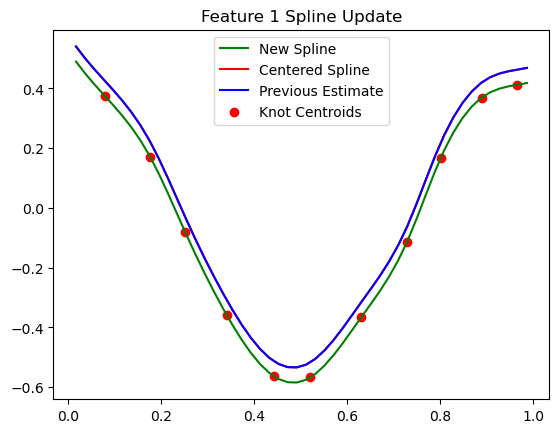

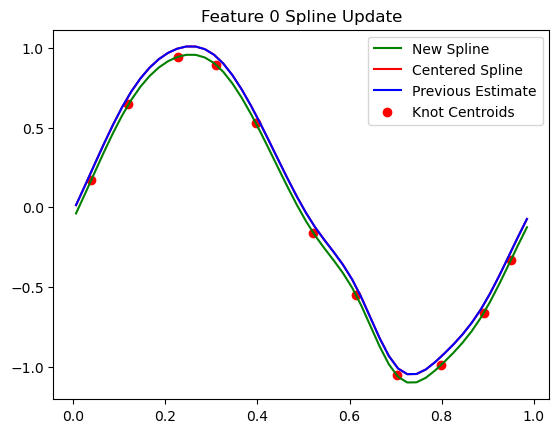

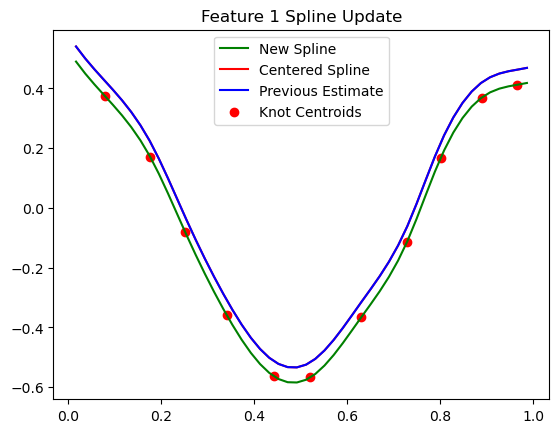

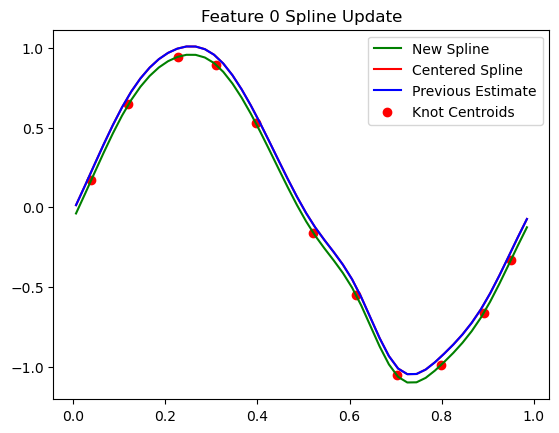

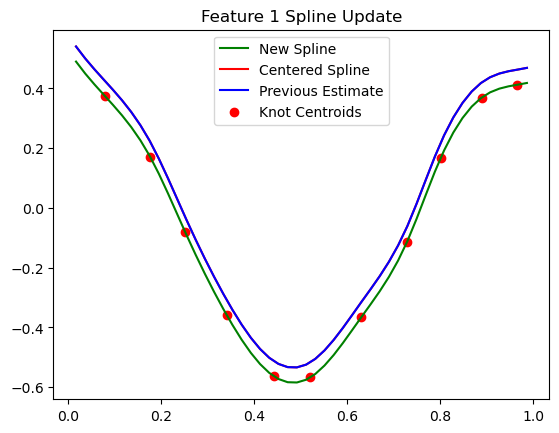

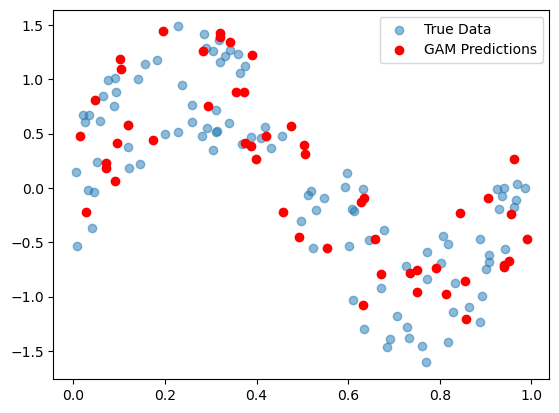

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 2)  # Two features
Y = np.sin(2 * np.pi * X[:, 0]) + 0.5 * np.cos(2 * np.pi * X[:, 1]) + np.random.normal(0, 0.1, 100)

feature_types = ['s', 's']


gam_model = linearGAM_competitor_improved_spline(X, Y, feature_types,verbose= True)

# Evaluate the model on new data
X_test = np.random.rand(50, 2)
Y_pred = gam_model(X_test)

# Plot results
plt.scatter(X[:, 0], Y, label="True Data", alpha=0.5)
plt.scatter(X_test[:, 0], Y_pred, color='red', label="GAM Predictions")
plt.legend()
plt.show()